In [1]:
import matplotlib.pylab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from opt_einsum import contract,contract_path
from tqdm.auto import tqdm
import dacite
import torch
from scipy.optimize import curve_fit
from functools import partial,wraps,reduce
import pickle
def _toN(t):
    return t.detach().cpu().tolist()
def _toT(t):
    return torch.as_tensor(t)

torch.set_default_tensor_type(torch.cuda.DoubleTensor)
torch.cuda.set_device(0)

In [2]:
import importlib
import HOTRGZ2,TNModels,GILT,utils,ScalingDimensions,fix_gauge
importlib.reload(fix_gauge)
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(ScalingDimensions)
importlib.reload(GILT)
importlib.reload(utils)
from HOTRGZ2 import forward_observable_tensor,forward_observable_tensors,trace_tensor,trace_two_tensors,get_lattice_size,get_dist_torus_2D
from HOTRGZ2 import HOTRG_layers,GILT_options,MCF_options
from TNModels import Ising2D,AKLT2D,AKLT2DStrange
from ScalingDimensions import show_effective_rank,show_diff,show_scaling_dimensions,show_asymmetry

# TRG Evolution

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

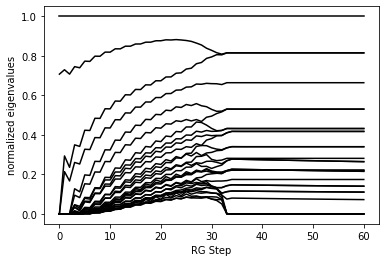

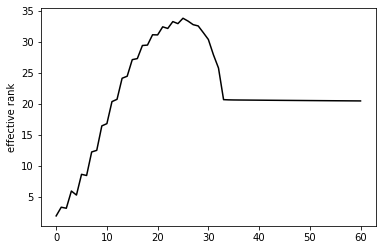

  0%|          | 0/61 [00:00<?, ?it/s]

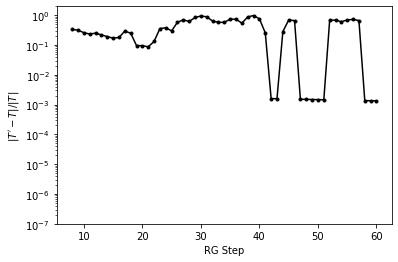

  0%|          | 0/61 [00:00<?, ?it/s]

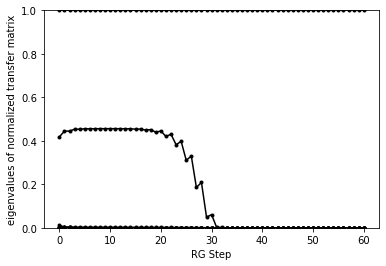

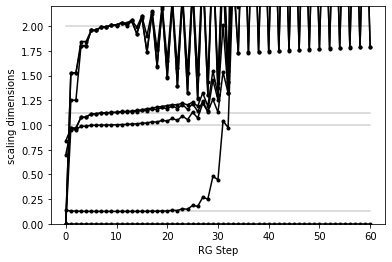

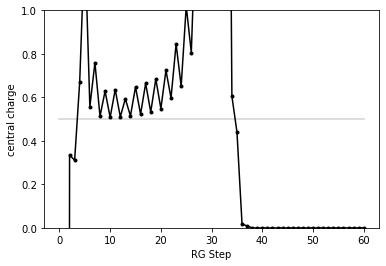

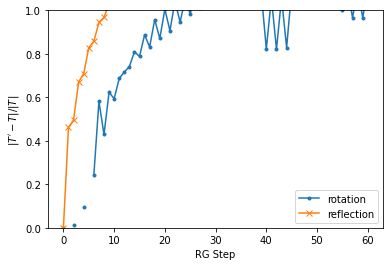

,layer,asym_rot,asym_ref
0,0.0,0.000000,0.000000
1,1.0,NaN,0.461534
2,2.0,0.015117,0.495595
3,3.0,NaN,0.670858
4,4.0,0.097188,0.709035
...,...,...,...
56,56.0,1.103424,1.338111
57,57.0,0.965883,1.338078
58,58.0,1.103182,1.338045
59,59.0,0.965822,1.338012


In [7]:
data=pd.DataFrame()
options={
    'nLayers':60,
    'max_dim':24,
    'gilt_enabled':False,
    'gilt_eps':8e-7,
    'gilt_nIter':1,
    'mcf_enabled':True,
    'mcf_eps':1e-6,
    'mcf_max_iter':50,
}

#params=AKLT2D.get_default_params()
#params['a2']=2.86522
#params['a2']=2.86521
#model=AKLT2D(params)
#T0=model.get_T0()
#T0_op1,T0_op2,checkerboard=model.get_ST0(2),model.get_ST0(2),True


params=Ising2D.get_default_params()
#params['beta']-=.00001
#params['beta']+=.00001
model=Ising2D(params)
T0=model.get_T0()
T0_op1,T0_op2,checkerboard=model.get_SZT0(),model.get_SZT0(),False


#params=AKLT2DStrange.get_default_params()
#model=AKLT2DStrange(params)
#T0=model.get_T0()
#T0_op1,T0_op2=model.get_ST0(0)+model.get_ST0(1),model.get_ST0(0)-model.get_ST0(1)
#checkerboard=False

reference_scaling_dimensions=[0.125,1,1.125,2]
reference_center_charge=.5

#dimR=model.get_dimR()
dimR=None

layers,Ts,logTotals=HOTRG_layers(T0,dimR=dimR,
                        max_dim=options['max_dim'],nLayers=options['nLayers'],
                        options=options,
                        return_tensors=True)

#Ts_new,T_ops,logTotals=forward_observable_tensor(T0,T0_op1,
#                        layers=layers,checkerboard=model.observable_checkerboard,
#                        return_layers=True,
#                        cached_Ts=None)

#print(trace_two_tensors(T_ops[-1]))
    
#print(max((a-b).norm() for a,b in zip(Ts,Ts_new)))
show_effective_rank(Ts)
show_diff(Ts,stride=2)
#show_diff(fix_gauge.fix_gauges1(Ts,is_HOTRG=True),stride=2)
curve=show_scaling_dimensions(Ts,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=reference_scaling_dimensions,reference_center_charge=reference_center_charge)
show_asymmetry(Ts)

# correlators

In [10]:
data=pd.DataFrame()

coordss=[]
for i in range(100):
    lattice_size=get_lattice_size(len(layers),spacial_dim=len(T0.shape)//2)
    th=np.random.uniform(0,np.pi/2)
    r=np.exp(np.random.uniform(np.log(1),np.log(min(lattice_size))))
    x,y=int(np.abs(r*np.cos(th))),int(np.abs(r*np.sin(th)))
    coordss.append((x,y))
    #x,y=int(lattice_size[0]-r),0
    #coordss.append((x,y))
    #x,y=int(r),0
    #coordss.append((x,y))

for coords in tqdm(coordss):
    if not(all(isinstance(c,int) and 0<=c and c<s for c,s in zip(coords,lattice_size))):continue
    if all(c==0 for c in coords):continue
        

    T,T_op12,logTotal=forward_observable_tensors(T0,[T0_op1,T0_op2],[(0,)*len(coords),coords],\
                               layers=layers,checkerboard=checkerboard,\
                               cached_Ts=Ts)
    correlation=_toN(trace_tensor(T_op12)/trace_tensor(T))
    newRow={**params,
        **options,
        'x':coords[0],'y':coords[1],
        'correlation':correlation,}
    
    data=data.append(newRow,ignore_index=True)
#data

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [66]:
def save_data(name,data,options,params):
    data.to_pickle(name+'.curve')
    f=open(name+'.params','wb')
    pickle.dump((options,params),f)
    f.close()
def load_data(name):
    data=pd.read_pickle(name+'.curve')
    f=open(name+'.params','rb')
    options,params=pickle.load(f)
    f.close()
    return data,options,params

In [56]:
#save_data('CorrLowT',data,options,params)
#save_data('CorrLowTNoGilt',data,options,params)
#save_data('CorrHighTNoGilt',data,options,params)

In [10]:
#data,options,params=load_data('CorrLowT')
#data,options,params=load_data('CorrLowTNoGilt')
#data,options,params=load_data('CorrHighTNoGilt')

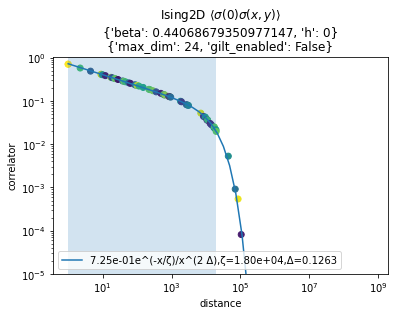

In [12]:
assert(all(data['correlation']>=-1e-7))

data['dist']=get_dist_torus_2D(data['x'].to_numpy(),data['y'].to_numpy(),lattice_size)
data['correlation_abs']=np.abs(data['correlation'])


data['theta']=np.arctan2(data['x'],data['y'])


def ansatz1(x,A,zeta,delta): #high temperature
    return A*np.exp(-x/zeta)*x**(-2*delta)
ansatz1_eq='{0:.2e}e^(-x/ζ)/x^(2 Δ),ζ={1:.2e},Δ={2:.4f}'
ansatz1_p0=(1,100,0.1)

def ansatz3(x,A,zeta,delta,n): #low temperature
    return A*(1+(zeta/x)**n)**(2*delta/n)
ansatz3_eq='{0:.2e}(1+(ζ/x)^n)^(2 ∆/n),ζ={1:.2e},∆={2:.4f},n={3:.1f}'
ansatz3_p0=(1,100,0.1,2)

def ansatz4(x,A,zeta,delta):  #low temperature
    return A*(1/zeta+1/x)**(2*delta)
ansatz4_eq='{0:.2e}(1/ζ+1/x)^(2 ∆),ζ={1:.2e},∆={2:.4f}'
ansatz4_p0=(1,100,0.1)

def ansatz5(x,A,zeta,delta,m0):  #low temperature nikko
    return A*np.exp(-x/zeta)*x**(-2*delta)+m0**2
ansatz5_eq='{0:.2e}e^(-x/ζ)/x^(2 Δ)+m0^2,ζ={1:.2e},Δ={2:.4f},m0={3:.3f}'
ansatz5_p0=(1,1000,0.1,0.1)


    

def loglog(foo):
    @wraps(foo)
    def goo(logX,*p):
        return np.log(foo(np.exp(logX),*p))
    return goo


if data['correlation_abs'].min()<1e-5:
    ansatz,ansatz_eq,ansatz_p0=ansatz1,ansatz1_eq,ansatz1_p0
    threshold=min(data[data['correlation_abs']>1e-2]['dist'].max(),2**(options['nLayers']//2-5))
else:
    #ansatz,ansatz_eq,ansatz_p0=ansatz3,ansatz3_eq,ansatz3_p0
    ansatz,ansatz_eq,ansatz_p0=ansatz4,ansatz4_eq,ansatz4_p0
    #ansatz,ansatz_eq,ansatz_p0=ansatz5,ansatz5_eq,ansatz5_p0
    threshold=2**(options['nLayers']//2-5)

data1=data[(data['dist']<threshold)].sort_values('dist')

try:
    p,cov=curve_fit(loglog(ansatz),np.log(data1['dist']),np.log(data1['correlation_abs']),p0=ansatz_p0,maxfev=10000)
except Exception as err:
    print(err)
    p,cov=None,None

data1=data.sort_values('dist')
plt.scatter(data1['dist'],data1['correlation_abs'],c=data1['theta'])
if p is not None:
    ls=np.geomspace(data1['dist'].min(),data1['dist'].max())
    plt.plot(ls,ansatz(ls,*p),'-',label=ansatz_eq.format(*p))
    plt.legend()
#plt.axvline(threshold,color='black')
plt.axvspan(1,threshold, alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlator')
plt.ylim([max(1e-5,data['correlation_abs'].min()*.5),data['correlation'].max()*1.5])
#plt.title(f'{type(model).__name__} HOTRG {correlator_name}\n{params}\n{options}')
show_options=['max_dim']
if options.get('gilt_enabled',False):
    show_options.extend(['gilt_eps'])
else:
    show_options.extend(['gilt_enabled'])
    
correlator_name=r'$\langle\sigma(0)\sigma(x,y)\rangle$'

plt.title(f'{type(model).__name__} {correlator_name}\n{params}\n{ {k:options[k] for k in show_options} }')
plt.show()

# correlators on a torus

In [25]:
data=pd.DataFrame()

correlator_name=r'$\langle\phi(0,0)\phi(x,0)\rangle$'
coordss=[]
layers1=layers[:60]
lattice_size=get_lattice_size(len(layers1),spacial_dim=len(T0.shape)//2)
#for i in range(50):
#    r=np.exp(np.random.uniform(np.log(1),np.log(min(lattice_size))))
#    x,y=int(r),0
#    coordss.append((x,y))
#    x,y=int(lattice_size[0]-1-r),0
#    coordss.append((x,y))

for r in [0,1,2,3,4,10,30,100,300,1000,3000,10000,30000,100000,300000]:
    if r<lattice_size[0]:
        x,y=int(r),0
        coordss.append((x,y))
        x,y=int(lattice_size[0]-1-r),0
        coordss.append((x,y))


for coords in tqdm(coordss):
    if not(all(isinstance(c,int) and 0<=c and c<s for c,s in zip(coords,lattice_size))):continue
    if all(c==0 for c in coords):continue
        

    T,T_op12,logTotal=forward_observable_tensors(T0,[T0_op1,T0_op2],[(0,)*len(coords),coords],\
                               layers=layers1,checkerboard=checkerboard,\
                               cached_Ts=Ts)
    correlation=_toN(trace_tensor(T_op12)/trace_tensor(T))
    newRow={**params,
        **options,
        'x':coords[0],'y':coords[1],
        'correlation':correlation,}
    
    data=data.append(newRow,ignore_index=True)

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [28]:
import mpmath
jtheta = np.vectorize(mpmath.jtheta, 'D') #https://mpmath.org/doc/current/functions/elliptic.html#jacobi-theta-functions
def torus_correlation(x,y,sizeX,sizeY):
    tau=1j * sizeY/sizeX
    # compare to the big yellow book: 
    #     q_y=e^(2ipi tau)=q^2, z_y=z/pi
    z=np.pi*(x+1j * y)/sizeX
    q=np.exp(1j*np.pi*tau) 
    coeff=np.abs(jtheta(n=1,z=0,q=q,derivative=1)/jtheta(n=1,z=z,q=q))**0.25
    A=sum(np.abs(jtheta(n=n,z=z/2,q=q))for n in [1,2,3,4])
    B=sum(np.abs(jtheta(n=n,z=0,q=q))for n in [2,3,4])
    return coeff*A/B

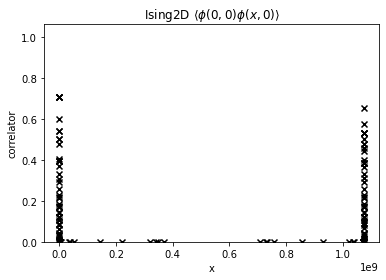

{'nLayers': 60, 'max_dim': 24, 'gilt_enabled': False, 'gilt_eps': 8e-07, 'gilt_nIter': 1, 'mcf_enabled': True, 'mcf_eps': 1e-06, 'mcf_max_iter': 50}


In [29]:
assert(all(data['correlation']>=-1e-7))

data['correlation_abs']=np.abs(data['correlation'])

def ansatz6(x,A):  #torus
    return A*torus_correlation(x,0,*lattice_size)
#ansatz6_eq=r'$\left|\frac{\partial_z\theta_1(0|\tau)}{\theta_1(z|\tau)}\right|^{\frac{1}{4}}\;\frac{\sum_{\nu=1}^4|\theta_\nu(z/2|\tau)|}{\sum_{\nu=2}^4|\theta_\nu(0|\tau)|}$'
ansatz6_eq=r'🍩(x,0)'
ansatz6_eq='{0:.3f}'+ansatz6_eq.replace('{','{{').replace('}','}}')
ansatz6_p0=(1)

ansatz,ansatz_eq,ansatz_p0=ansatz6,ansatz6_eq,ansatz6_p0

try:
    p,cov=curve_fit(ansatz,data['x'],data['correlation_abs'],p0=ansatz_p0,maxfev=10000)
except Exception as err:
    print('error',err)
    p,cov=None,None


#if p is not None:
#    ls=np.linspace(data['x'].min(),data['x'].max())
#    plt.plot(ls,ansatz(ls,*p),'-',label='curve fit')
#    print(p)
#    plt.legend()

plt.scatter(data['x'],data['correlation_abs'],marker='x',color='black')
plt.xlabel('x')
plt.ylabel('correlator')
plt.ylim([0,data['correlation'].max()*1.5])


#plt.title(f'{type(model).__name__} HOTRG {correlator_name}\n{params}\n{options}')
plt.title(f'{type(model).__name__} {correlator_name}')
plt.show()
print(options)

In [49]:
2**30

1073741824

In [45]:
lattice_size

(1073741824, 1073741824)

# Magnetization Curve

In [5]:
data=pd.DataFrame()
options={
    'nLayers':60,
    'max_dim':12,
    'gilt_enabled':True,
    'gilt_eps':8e-7,
    'gilt_nIter':1,
    'mcf_enabled':True,
    'mcf_eps':1e-6,
    'mcf_max_iter':50,
}

Model=Ising2D
sweeping_param_name='beta'
sweeping_param_midpoint=0.44068679350977147
sweeping_param_halfrange=0.00001

#Model=AKLT2D
#sweeping_param_name='a2'
#sweeping_param_midpoint=2.86522
#sweeping_param_halfrange=.01

for param in tqdm(np.linspace(-sweeping_param_halfrange,sweeping_param_halfrange,9)+sweeping_param_midpoint,leave=False):
    params={sweeping_param_name:param}
    model=Model(params)
    dimR=None
    
    layers,Ts,logTotals=HOTRG_layers(model.get_T0(),dimR=dimR,
                            max_dim=options['max_dim'],nLayers=options['nLayers'],
                            options=options,
                            return_tensors=True)
    
    rows=[]
    for iLayer in range(len(Ts)):
        T,logTotal=Ts[iLayer],logTotals[iLayer]
        logZ=_toN((torch.log(trace_tensor(T))+logTotal)/2**iLayer)
        rows.append({
            **params,
            **options,
            'layer':iLayer,
            'logZ':logZ,
        })
        
    for observable in model.get_observables():
        Ts,T_ops,logTotals=forward_observable_tensor(model.get_T0(),observable.T0,
                                        layers=layers,checkerboard=observable.checkerboard,
                                        return_layers=True,
                                        cached_Ts=Ts)
        for iLayer in range(len(Ts)):
            T,T_op=Ts[iLayer],T_ops[iLayer]
            rows[iLayer][observable.name]=_toN((trace_two_tensors(T_op)/trace_two_tensors(T))**.5)
            rows[iLayer][observable.name+'_onepoint']=_toN((trace_two_tensors(T_op)/trace_two_tensors(T))**.5)
        
        
    data=data.append(rows,ignore_index=True)
#display(data)



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

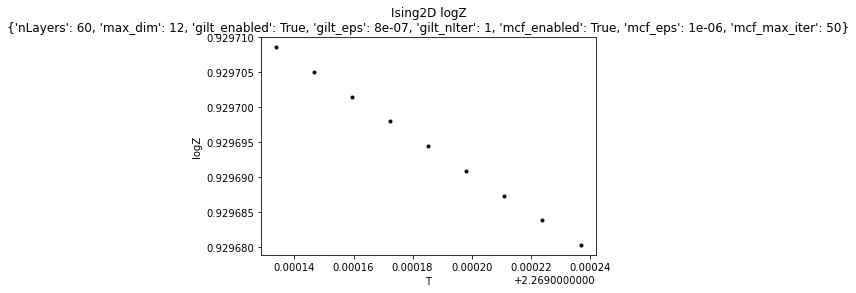

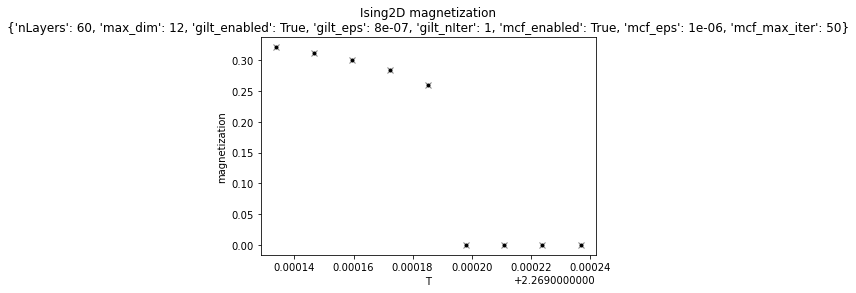

In [5]:
if sweeping_param_name == 'beta':
    data['T']=1./data['beta']
    sweeping_param_name='T'
    
observable_names=[observable.name for observable in model.get_observables()]
    
if 'magnetizationX' in observable_names:
    data['magnetizationXY']=(data['magnetizationX']**2+data['magnetizationY']**2)**.5
    data['magnetizationXY_onepoint']=(data['magnetizationX_onepoint']**2+data['magnetizationY_onepoint']**2)**.5
    observable_names.append('magnetizationXY')

data1=data[(data['layer']==options['nLayers'])]
plt.plot(data1[sweeping_param_name],data1['logZ'],'.',color='black')
plt.xlabel('T')
plt.ylabel('logZ')
plt.title(f'{type(model).__name__} logZ\n{options}')
plt.show()


for observable_name in observable_names:
    data1=data[(data['layer']==options['nLayers'])]
    plt.plot(data1[sweeping_param_name],data1[observable_name+'_onepoint'],'x',color='grey')
    plt.plot(data1[sweeping_param_name],data1[observable_name],'.',color='black')
    plt.xlabel(sweeping_param_name)
    plt.ylabel(observable_name)
    plt.title(f'{type(model).__name__} {observable_name}\n{options}')
    plt.show()
    

# diagonal TRG method

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

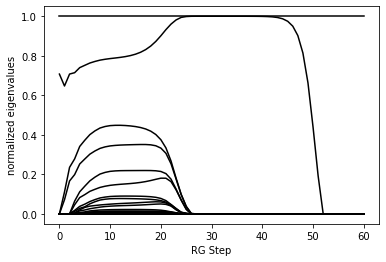

  0%|          | 0/61 [00:00<?, ?it/s]

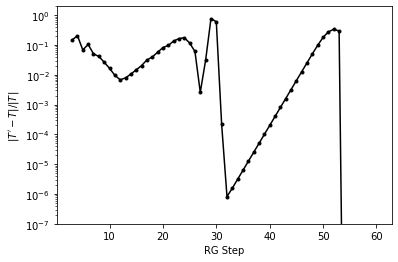

  0%|          | 0/61 [00:00<?, ?it/s]

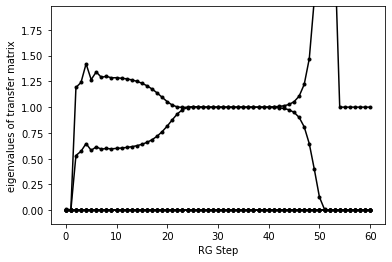

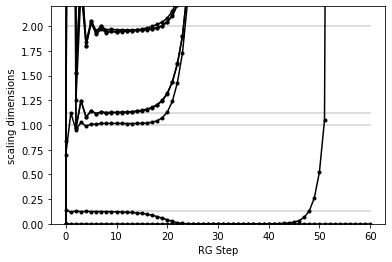

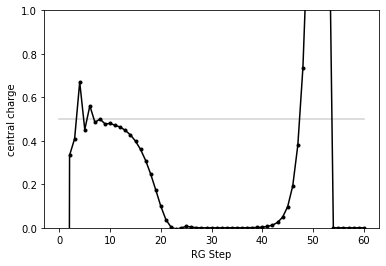

In [17]:
options={
    'nLayers':60,
    'max_dim':12,
    'gilt_enabled':True,
    'gilt_eps':8e-7,
    'gilt_nIter':1,
    'gilt_TRG_method':'A',
}
gilt_options=GILT_options(**{k[5:]:v for k,v in options.items() if k[:5]=='gilt_'})


#critical beta: 0.44068679350977147
params={'beta':.4409}
#params={'beta':0.44068679350977147}#critical
model=Ising2D(params)



Ts,logNorms=evolve_TRG_GILT_2D(model.get_T0(),
                               nLayers=options['nLayers'],max_dim=options['max_dim'],
                               options=gilt_options,
                               return_layers=True)
show_effective_rank(Ts)
show_diff(Ts)
curve=show_scaling_dimensions(Ts,loop_length=2,reference_scaling_dimensions=[0.125,1,1.125,2],reference_center_charge=.5)
# two_pass seems give higher cT: one_pass=.440606 two_pass=.440618 ref=.440686 max_dim=8
# not spliting insertion greatly changes cT: one_pass=.440298 two_pass=.440803 max_dim=8

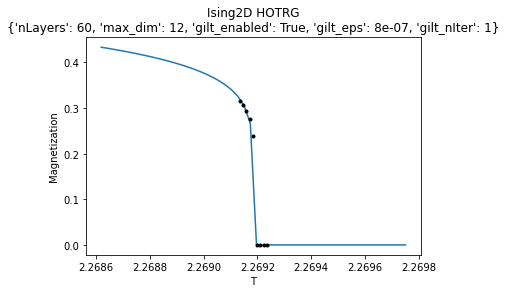

/home/wenhan/jupyter/SRG/IsingSolutions.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I,abserr=scipy.integrate.quad(integrant,0,pi,epsabs=0,epsrel=1e-12)


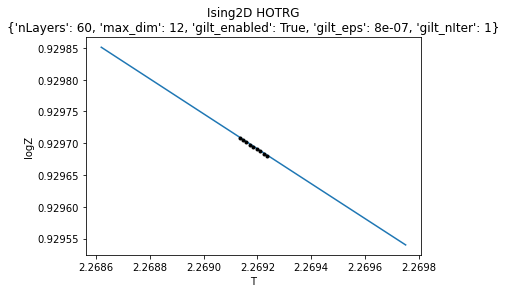

In [61]:

import IsingSolutions
importlib.reload(IsingSolutions)
from IsingSolutions import Ising2DExactSolution,Ising3DMonteCarlo

solution=Ising2DExactSolution()
nLayers=int(max(data['layer']))

def relerr(x,ref):
    return abs(x-ref)/abs(ref)

def abserr(x,ref):
    return abs(x-ref)

ls=np.linspace(min(data['beta'])-.0001,max(data['beta'])+.0001)


plt.plot(1/ls,solution.magnetization(ls))
data1=data[(data['layer']==nLayers)]
plt.plot(1/data1['beta'],data1['magnetization'],'.',color='black')
#plt.plot(1/data1['beta'],data1['magnetization1'],'x')
plt.xlabel('T')
plt.ylabel('Magnetization')
plt.title(f'{type(model).__name__} HOTRG\n{options}')
plt.show()

plt.plot(1/ls,solution.logZ(ls))
data1=data[(data['layer']==nLayers)]
plt.plot(1/data1['beta'],data1['logZ'],'.',color='black')
plt.xlabel('T')
plt.ylabel('logZ')
plt.title(f'{type(model).__name__} HOTRG\n{options}')
plt.show()
    


In [202]:
from utils import show_tensor_ijkl,show_tensor_ikjl

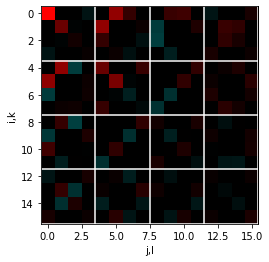

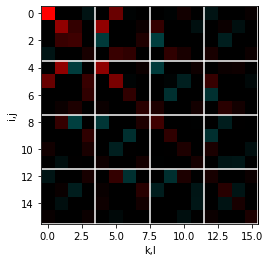

In [ ]:

from fix_gauge import fix_unitary_gauge
from HOTRGZ2 import reflect_tensor_axis,permute_tensor_axis
T=Ts[20];
show_tensor_ikjl(T,max_dim=4);plt.show()
show_tensor_ijkl(T,max_dim=4);plt.show()
print(T.norm(),T.max())
#Tref=reflect_tensor_axis(T)
Tref=permute_tensor_axis(T)
#T,_=fix_unitary_gauge(T,Tref)


show_tensor_ikjl(Tref,max_dim=4);plt.show()
show_tensor_ijkl(Tref,max_dim=4);plt.show()

show_tensor_ijkl(T-Tref,max_dim=4);plt.show()
show_tensor_ikjl(T-Tref,max_dim=4);plt.show()
print((T-Tref).norm(),(T-Tref).max())